In [1]:
! pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn xgboost

In [2]:
# Credit Card Fraud Detection Pipeline
# ============================================

# Step 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [3]:
# Step 1: Load Dataset & EDA
# --------------------------------------------
data = pd.read_csv(r"C:\Users\bbuser\Downloads\creditcard.csv")

print("Dataset shape:", data.shape)
print("\nFirst 5 rows:\n", data.head())
print("\nData Info:\n")
print(data.info())
print("\nSummary Stats:\n", data.describe())



Dataset shape: (284807, 31)

First 5 rows:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0


Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


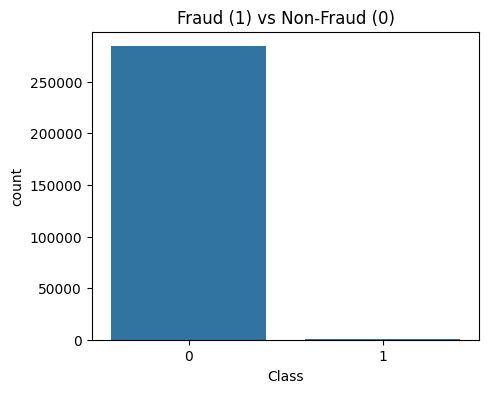

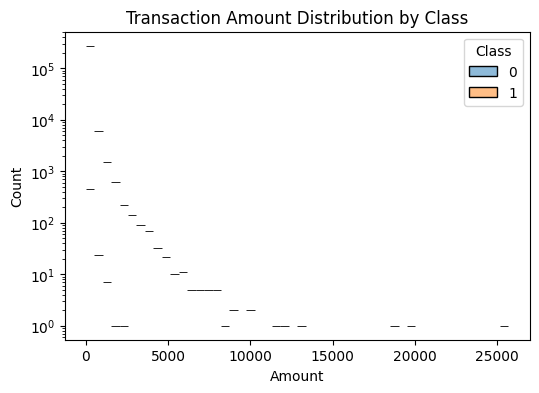

In [4]:
# Fraud vs Non-Fraud
print("\nClass Distribution:\n", data['Class'].value_counts())
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=data)
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

# Distribution of transaction amount
plt.figure(figsize=(6,4))
sns.histplot(data=data, x="Amount", hue="Class", log_scale=(False, True), bins=50)
plt.title("Transaction Amount Distribution by Class")
plt.show()

In [5]:
# Step 2: Data Preprocessing
# --------------------------------------------
X = data.drop(columns=['Class'])
y = data['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split (to preserve imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
# Step 3: Evaluation Function
# --------------------------------------------
def evaluate_and_plot(name, y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{name} Metrics:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Legit','Fraud'])
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC & Precision-Recall if probability scores available
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)
            print(f"  ROC-AUC  : {auc:.4f}")
            fpr, tpr, _ = roc_curve(y_true, y_score)
            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
            plt.plot([0,1],[0,1],'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{name} ROC Curve")
            plt.legend()
            plt.show()
        except Exception as e:
            print("ROC could not be computed:", e)

        avg_prec = average_precision_score(y_true, y_score)
        print(f"  Avg Precision (AP): {avg_prec:.4f}")
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(6,4))
        plt.plot(recall, precision, label=f'AP={avg_prec:.3f}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{name} Precision-Recall Curve")
        plt.legend()
        plt.show()



Logistic Regression Metrics:
  Accuracy : 0.9755
  Precision: 0.0608
  Recall   : 0.9184
  F1-score : 0.1141


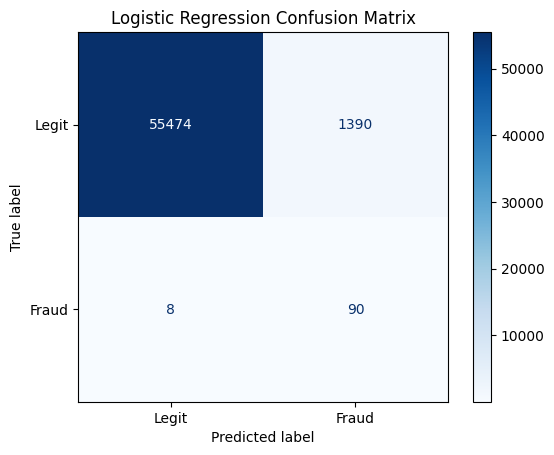

  ROC-AUC  : 0.9721


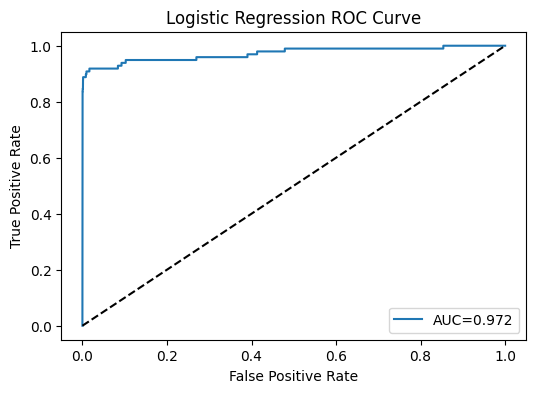

  Avg Precision (AP): 0.7189


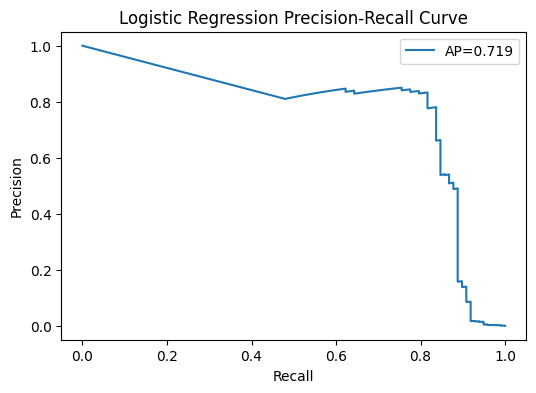


Decision Tree Metrics:
  Accuracy : 0.9989
  Precision: 0.6762
  Recall   : 0.7245
  F1-score : 0.6995


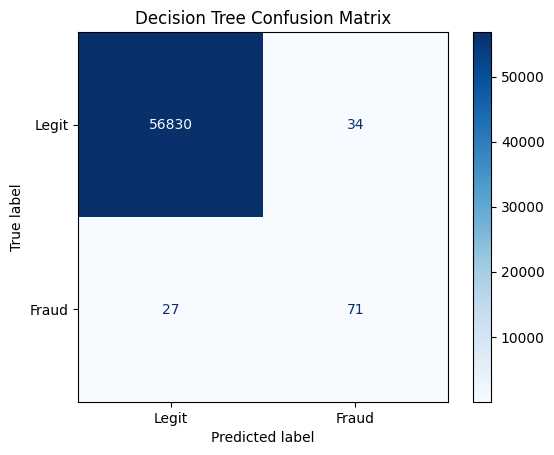

  ROC-AUC  : 0.8619


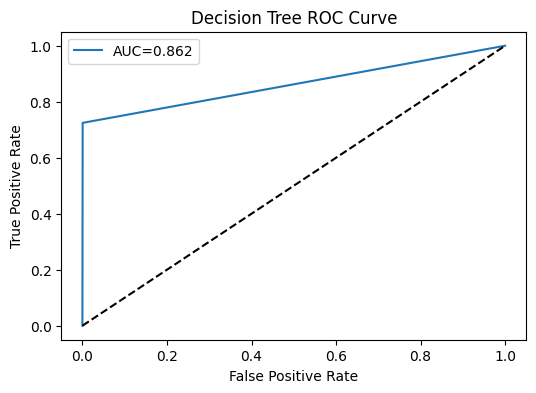

  Avg Precision (AP): 0.4904


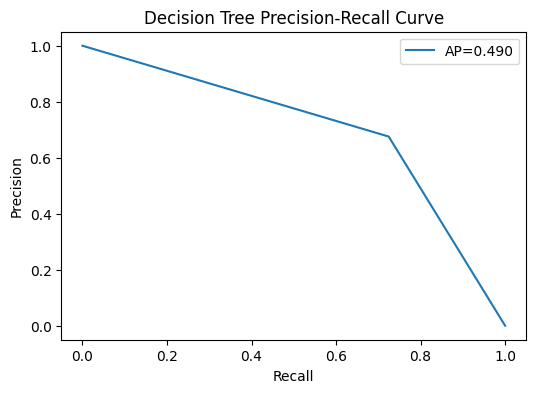

In [ ]:
# Step 4: Baseline Models
# --------------------------------------------

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_score_lr = lr.predict_proba(X_test)[:,1]
evaluate_and_plot("Logistic Regression", y_test, y_pred_lr, y_score_lr)

# Decision Tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_score_dt = dt.predict_proba(X_test)[:,1]
evaluate_and_plot("Decision Tree", y_test, y_pred_dt, y_score_dt)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]
evaluate_and_plot("Random Forest", y_test, y_pred_rf, y_score_rf)

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.predict_proba(X_test)[:,1]
evaluate_and_plot("SVM", y_test, y_pred_svm, y_score_svm)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.1,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), # handle imbalance
    eval_metric="logloss", use_label_encoder=False, random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_score_xgb = xgb_clf.predict_proba(X_test)[:,1]
evaluate_and_plot("XGBoost", y_test, y_pred_xgb, y_score_xgb)

Model Comparison (Your Results)
Metric	Logistic Regression	Decision Tree
Accuracy	0.9755	0.9989
Precision	0.0608	0.6762
Recall	0.9184	0.7245
F1-score	0.1141	0.6995
ROC-AUC	0.9721	0.8619
Avg Precision	0.7189	0.4904
🔹 Insights
Logistic Regression

Strength → Extremely high recall (0.9184) → catches almost all fraud cases.

Weakness → Very low precision (0.0608) → for every 100 flagged frauds, ~94 are false alarms.

ROC-AUC (0.9721) → shows it’s very good at ranking fraud vs. non-fraud probabilities.

Conclusion → Best when the goal is to catch as many frauds as possible, even at the cost of investigating many false positives.

Decision Tree

Strength → Balanced precision (0.6762) and recall (0.7245) → fewer false alarms and still decent fraud detection.

Weakness → ROC-AUC lower (0.8619), meaning it struggles at ranking fraud probabilities compared to Logistic Regression.

F1-score (0.6995) → much higher than Logistic Regression because of balance between precision and recall.

Conclusion → Better when the goal is to reduce false alarms, but it might miss more frauds than Logistic Regression.

🔹 Trade-offs

Logistic Regression → High recall, low precision (good for banks who want to catch all possible frauds).

Decision Tree → Balanced recall + precision, but misses more frauds.

Accuracy is misleading here because the data

## Summary:

## If catching frauds is most important → Logistic Regression is better (high recall).

## If reducing false alarms is most important → Decision Tree is better (high precision & F1).

## Best practical approach → Use ensemble models (Random Forest/XGBoost) + threshold tuning to get both high recall and high precision.